In [74]:
import numpy as np
import math
import random
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
%matplotlib inline

# FUNCIONES

In [3]:
#Encontrar la cantidad optima de unidades del SOM
def mapunits(input_len):
    heuristic_map_units = 20*input_len**0.54321
    return heuristic_map_units

In [63]:
#Algoritmo SOM

def som(observations,map_width,map_height,epochs):
    MAP = np.random.uniform(size=(map_height,map_width,len(observations[0])))
    prev_MAP = np.zeros((map_height,map_width,len(observations[0])))

    radius0 = max(map_width,map_height)/2
    learning_rate0 = 0.1

    coordinate_map = np.zeros([map_height,map_width,2],dtype=np.int32)

    for i in range(0,map_height):
        for j in range(0,map_width):
            coordinate_map[i][j] = [i,j]


    radius=radius0
    learning_rate = learning_rate0
    max_iterations = len(observations)+1
    too_many_iterations = 10*max_iterations

    convergence = [1]

    timestep=1
    e=0.001 #determinación de la convergencia
    flag=0 #Cuando es igual a 1 significa que la red llego a un punto estacionario

    epoch=0
    while epoch<epochs:

        shuffle = np.random.randint(len(observations), size=len(observations))
        for i in range(len(observations)):

            # Revisamos si la red ha convergido
            J = np.linalg.norm(MAP - prev_MAP)

            if  J <= e:
                flag=1
                break

            else:

                #if timestep == max_iterations and timestep != too_many_iterations:
                #    epochs += 1
                #    max_iterations = epochs*len(observations)

                observation = observations[shuffle[i]]
                observation_ary = np.tile(observation, (map_height, map_width, 1))
                Eucli_MAP = np.linalg.norm(observation_ary - MAP, axis=2)
                
                BMU = np.unravel_index(np.argmin(Eucli_MAP, axis=None), Eucli_MAP.shape)    

                prev_MAP = np.copy(MAP)

                for i in range(map_height):
                    for j in range(map_width):
                        distance = np.linalg.norm([i - BMU[0], j - BMU[1]])
                        if distance <= radius:
                            #theta = math.exp(-(distance**2)/(2*(radius**2)))
                            MAP[i][j] = MAP[i][j] + learning_rate*(observation-MAP[i][j]) #Agregar un cambio dependiente de la distancia!

                learning_rate = learning_rate0*(1-(epoch/epochs))
                #time_constant = max_iterations/math.log(radius) 
                radius = radius0*math.exp(-epoch/epochs)

                timestep+=1

        if J < min(convergence):
            print('Lower error found: %s' %str(J) + ' at epoch: %s' % str(epoch))
            print('\tLearning rate: ' + str(learning_rate))
            print('\tNeighbourhood radius: ' + str(radius))
            MAP_final = MAP
        convergence.append(J)

        
        if flag==1:
            break
        epoch+=1
    return convergence, J, timestep

In [78]:
patterns = []
classes = []

filename = 'Iris.txt'
file = open(filename,'r')

for line in file.readlines():
    row = line.strip().split(',')
    patterns.append(row[0:4])
    classes.append(row[4])
print("Iris Data Loaded")
file.close

patterns = np.asarray(patterns,dtype=np.float32)

sample_no = np.random.randint(0,len(patterns))

print("Sample pattern: " + str(patterns[int(sample_no)]))
print("Class of the above pattern: " + str(classes[int(sample_no)]))

Iris Data Loaded
Sample pattern: [6.4 2.9 4.3 1.3]
Class of the above pattern: Iris-versicolor


In [65]:
convergence,J,timestep=som(patterns,9,5,500)

Lower error found: 0.3257884721156211 at epoch: 1
	Learning rate: 0.0998
	Neighbourhood radius: 4.491008994002999
Lower error found: 0.3183815072677504 at epoch: 24
	Learning rate: 0.0952
	Neighbourhood radius: 4.289102041848771
Lower error found: 0.2245791926063242 at epoch: 40
	Learning rate: 0.09200000000000001
	Neighbourhood radius: 4.154023558739861
Lower error found: 0.1795024426270464 at epoch: 74
	Learning rate: 0.0852
	Neighbourhood radius: 3.8809400172392046
Lower error found: 0.14397885910151062 at epoch: 115
	Learning rate: 0.07700000000000001
	Neighbourhood radius: 3.575401211265003
Lower error found: 0.13945608291408526 at epoch: 130
	Learning rate: 0.074
	Neighbourhood radius: 3.4697321361160482
Lower error found: 0.13869736804607138 at epoch: 137
	Learning rate: 0.0726
	Neighbourhood radius: 3.4214943386739693
Lower error found: 0.09971317741234417 at epoch: 173
	Learning rate: 0.0654
	Neighbourhood radius: 3.183806191979258
Lower error found: 0.08607699231778787 at epo

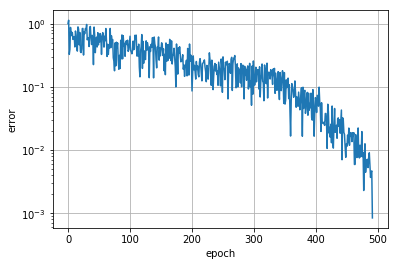

Number of timesteps: 73519
Final error: 0.0008461433214709044


In [66]:
# Show a plot of the error at each epoch to show convergence, but this is guaranteed in SOM
# due to the learning rate and neighbourhood decay
plt.plot(convergence)
plt.ylabel('error')
plt.xlabel('epoch')
plt.grid(True)
plt.yscale('log')
plt.show()
print('Number of timesteps: ' + str(timestep))
print('Final error: ' + str(J))

In [67]:
from scipy.misc import toimage
from PIL import Image


BMU = np.zeros([2],dtype=np.int32)
result_map = np.zeros([map_height,map_width,3],dtype=np.float32)

i=0
for pattern in patterns:
    
    pattern_ary = np.tile(pattern, (map_height, map_width, 1))
    Eucli_MAP = np.linalg.norm(pattern_ary - MAP_final, axis=2)

    # Get the best matching unit(BMU) which is the one with the smallest Euclidean distance
    BMU = np.unravel_index(np.argmin(Eucli_MAP, axis=None), Eucli_MAP.shape)
    
    x = BMU[0]
    y = BMU[1]
    
    if classes[i] == 'Iris-setosa':
        if result_map[x][y][0] <= 0.5:
            result_map[x][y] += np.asarray([0.5,0,0])
    elif classes[i] == 'Iris-virginica':
        if result_map[x][y][1] <= 0.5:
            result_map[x][y] += np.asarray([0,0.5,0])
    elif classes[i] == 'Iris-versicolor':
        if result_map[x][y][2] <= 0.5:
            result_map[x][y] += np.asarray([0,0,0.5])
    i+=1
result_map = np.flip(result_map,0)
    
#print result_map

print("Red = Iris-Setosa")
print("Blue = Iris-Virginica")
print("Green = Iris-Versicolor")

plt.imshow(result_map, interpolation='nearest')

NameError: name 'map_height' is not defined